In [1]:
#@title Import and Utilities

import numpy as np
import pandas as pd
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy

from utilities import *
from Torch_architectures import *
from Train_functions import *
from CD_utilities import *
from layers import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version: 1.11.0+cu113
Torchvision Version: 0.12.0+cu113
GPU is available? True


# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST
2. FMNIST
3. CIFAR10

# Train - test split

The Code for the Block Coordinate Descent was mostly based on https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb

In [58]:
#@title Dataset & Optimizer Selection
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

# change the flag to choose the dataset to work with
dataset_flag = "MNIST" #@param ['MNIST','FMNIST','CIFAR10']
batch_size = 256 #@param {type:"integer"}
if dataset_flag =='MNIST':
  trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)
  dataset_train = torch.utils.data.DataLoader(testset,batch_size = 128, shuffle = True)
  dataset_test = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)
elif dataset_flag =='FMNIST':
  trainset = datasets.FashionMNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=ts)
  dataset_train = torch.utils.data.DataLoader(testset,batch_size = 128, shuffle = True)
  dataset_test = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)
elif dataset_flag=='CIFAR10':
  trainset = datasets.CIFAR10('../data', train=True, download=True, transform=ts)
  testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=ts)
  dataset_train = torch.utils.data.DataLoader(testset,batch_size = 128, shuffle = True)
  dataset_test = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)

x_train, y_train, x_test, y_test,y_train_one_hot, y_test_one_hot, I1, I2 = load_dataset(trainset, testset,10)

# we move to device to use GPU

x_train = x_train.to(device = device)
x_test = x_test.to(device = device)
y_train = y_train.to(device = device)
y_test = y_test.to(device = device)
y_train_one_hot = y_train_one_hot.to(device)
y_test_one_hot = y_test_one_hot.to(device)
input_size = x_train.shape[0]
hidden_size = int(1.5*input_size)
output_size = 10

In [59]:
from torch.optim.lr_scheduler import MultiStepLR
#@title Model Selection
model_name = 'Multilayer-Perceptron' #@param ['Multilayer-Perceptron']
optimizer_name = "Coordinate-Descent+Adam" #@param ['SGD','Adam','Coordinate-Descent','Coordinate-Descent+SGD','Coordinate-Descent+Adam']
momentum = 0.9 #@param {type:"number"}
lr = 0.01 #@param {type:"number"}
weight_decay = 0.00 #@param {type:"number"}
beta_1 = 0.9 #@param {type:"number"}
beta_2 = 0.999 #@param {type:"number"}
gamma = 0.1 #@param {type:"number"}
alpha = 4 #@param {type:"number"}
epochs = 50 #@param {type:"integer"}
#the ratio of the epochs for coordinate descent for mixed classifiers
ratio =  0.6#@param {type:"number"}
GD_Update = False #@param {type:"boolean"}
linear_extension = False #@param {type:"boolean"}
cross_entropy = nn.CrossEntropyLoss()

if(model_name =='Multilayer-Perceptron'):
  model = MultiLayerPerceptron(input_size,hidden_size,output_size) 


if (optimizer_name == "SGD" or optimizer_name == "Coordinate-Descent+SGD"):
  #print("Got in SGD")
  optimizer = torch.optim.SGD(params=model.parameters(), lr=lr,
                              momentum=momentum, weight_decay=weight_decay)
  assert lr > 0
  assert 0 <= momentum <= 1
elif (optimizer_name == "Adam" or optimizer_name == "Coordinate-Descent+Adam"):
  #print("Got in Adam")
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, 
                               betas=(beta_1, beta_2), weight_decay=weight_decay)
if(optimizer_name != 'Coordinate-Descent'):
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.2)

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [60]:
train_losses = []
test_losses = []
accuracy_train = []
accuracy_test = []
epochs_times = []
start = time.time()
if(optimizer_name == 'Coordinate-Descent' or optimizer_name == 'Coordinate-Descent+SGD' or optimizer_name== 'Coordinate-Descent+Adam'):
  print('training BCD')
  if(optimizer_name != 'Coordinate-Descent'):
    total_epochs = epochs
    epochs = int(total_epochs * ratio)
  train_losses, test_losses , accuracy_train, accuracy_test,epochs_times,Ws,bs = execute_training([["Perceptron",hidden_size,1],["Perceptron",hidden_size,1]], input_size, hidden_size, output_size, x_train, x_test, y_train, y_test, y_train_one_hot, y_test_one_hot,
                                         GD_Update, linear_extension, I1 = hidden_size,I2=1, niter = epochs, gamma = gamma, alpha = alpha)
  #Train using BCD
  train_losses = list(train_losses)
  test_losses = list(test_losses)
  accuracy_train = list(accuracy_train)
  accuracy_test = list(accuracy_test)
  if(optimizer_name != 'Coordinate-Descent'):
    epochs = total_epochs-epochs
if(optimizer_name != 'Coordinate-Descent'):
  model = model.to(device)
  #train using sgd or adam
  if(optimizer_name == 'Coordinate-Descent+SGD' or optimizer_name == 'Coordinate-Descent+Adam'):
    i=0
    for param in model.parameters():
      if i%2 == 0:
        param.data = Ws[int(i/2)]
        #temp_W.pop()
      else:
        param.data = torch.flatten(bs[int(i/2)])
        #temp_b.pop()
      i+=1
  train_loss, test_loss, acc_train, acc_test, times = train_model(model, dataset_train, dataset_test, optimizer, cross_entropy, epochs,scheduler,optimizer_name)
  train_losses = list(train_losses) + train_loss
  test_losses = list(test_losses) + test_loss
  accuracy_train = list(accuracy_train) + acc_train
  accuracy_test = list(accuracy_test) + acc_test
  epochs_times = list(epochs_times) + times
elapsed_time = time.time() - start


training BCD
Epoch 1 / 30 
 - time: 0.978360652923584 - sq_loss: 1975.13671875 - tot_loss: 1975.136742599056 - loss_class: 22595.98828125 - acc: 0.6375333333333333 - val_acc: 0.6468
Epoch 2 / 30 
 - time: 0.970200777053833 - sq_loss: 1284.1158203125 - tot_loss: 1284.1158434288957 - loss_class: 21992.54296875 - acc: 0.8395666666666667 - val_acc: 0.8451
Epoch 3 / 30 
 - time: 0.9781675338745117 - sq_loss: 838.5617187500001 - tot_loss: 838.5617487589599 - loss_class: 21362.158203125 - acc: 0.8692 - val_acc: 0.8738
Epoch 4 / 30 
 - time: 0.9783272743225098 - sq_loss: 549.138916015625 - tot_loss: 549.1389494442199 - loss_class: 20788.904296875 - acc: 0.8793666666666666 - val_acc: 0.8854
Epoch 5 / 30 
 - time: 0.9776246547698975 - sq_loss: 360.18613281250003 - tot_loss: 360.1861787406277 - loss_class: 20294.98828125 - acc: 0.88505 - val_acc: 0.8893
Epoch 6 / 30 
 - time: 0.9792020320892334 - sq_loss: 236.48393554687502 - tot_loss: 236.4839974297647 - loss_class: 19878.4375 - acc: 0.888666666

In [55]:
#Replace this with the same function as DFW
results = {'epochs': epochs_times, 'train_losses': train_losses, 
           'train_acc': accuracy_train, 'test_losses': test_losses, 
           'test_acc': accuracy_test, 'elapsed_time': elapsed_time}
stats_dict = {}
stats_dict.update({optimizer_name: results})
save_stats = True
if(GD_Update):
  suffix = '-Entropy.pkl'
elif(linear_extension):
  suffix = '-linear_prox.pkl'
else:
  suffix = '.pkl'
print(optimizer_name)
# save everything onto file
if save_stats: 
    output_folder = os.path.join(os.getcwd(), dataset_flag)  # set the folder
    os.makedirs(output_folder, exist_ok=True)
    fname = output_folder + '/stats_dict_' + model_name + '_' + optimizer_name + suffix
    with open(fname, 'wb') as handle:
        pickle.dump(stats_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Coordinate-Descent


# Parameters used in the report

In order to reproduce our results, the following set of parameters should be used.\
If not specified, the remaining parameters (e.g. $\epsilon$ for Adam and Adagrad) are set to their default values.

Block Coordinate Descent:\
$\gamma = 0.1$, $\alpha = 4$

Stochastic Gradient Descent:\
$\gamma = 0.01$, $\mu = 0.9$, $w_d = 0$

Adam:\
$\gamma = 0.001$, $\mu = 0.9$, $\beta_1 = 0.9$, $\beta_2 = 0.99$

ratio:\
Mixing optimizers ratio = 0.6

For the mixed optimizer of SGD decrease the (learning rate) to $\gamma = 0.001$

# Producing the Plots

## Warning before proceeding to producing the plots make sure you have created the required dictionairies from the previous cells

1. Plotting for a dataset.
  - Run the SGD, Adam, Coordinate Descent, Coordinate Descent + Adam, for the dataset of your liking(We rsuggest MNIST, for CIFAR10 instead of Coordinate Descent + Adam use Coordinate Descent + SGD)
  - Enable the corresponing parameter in the next cell
2. Plotting the prox linear and normal Coordinate Descent Comparison
  - Run the Coordinate Descent, Coordinate Descent + linear prox, for the dataset of your liking(we suggest MNIST)
  - Enable the corresponding parameter in the next cell
3. Plotting the Block Coordinate Descent (GD update)
  - Run the Coordinate Descent Optimizer while enabling the GD_update for the dataset of your liking(we suggest MNIST)
  -Enable the corresponding parameter in the next cell

MNIST
Average Epoch Times:
Adam : 9.466000499725341
SGD : 9.32793261051178
Coordinate-Descent : 0.9772351026535034
Coordinate-Descent+Adam : 4.246522059440613
Test Accuracy:
Adam : 0.9641345084981715
SGD : 0.9457668223279587
Coordinate-Descent : 0.9371
Coordinate-Descent+Adam : 0.959319613842254


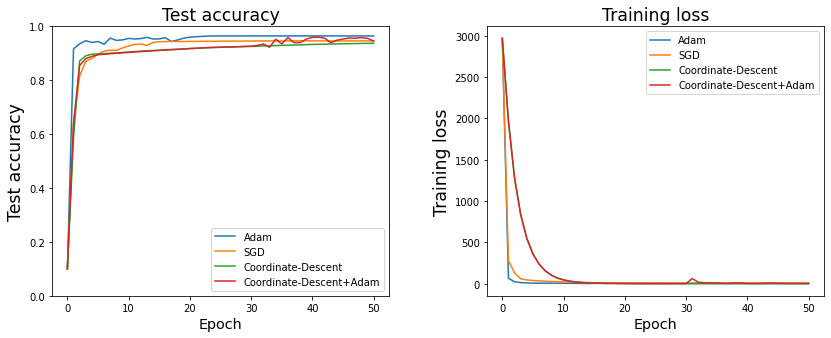

FMNIST
Average Epoch Times:
Adam : 9.499551157951355
SGD : 9.340507712364197
Coordinate-Descent : 0.9769915676116944
Coordinate-Descent+Adam : 4.369995708465576
Test Accuracy:
Adam : 0.8758754649060838
SGD : 0.865148471264129
Coordinate-Descent : 0.8423
Coordinate-Descent+Adam : 0.8717641627534907


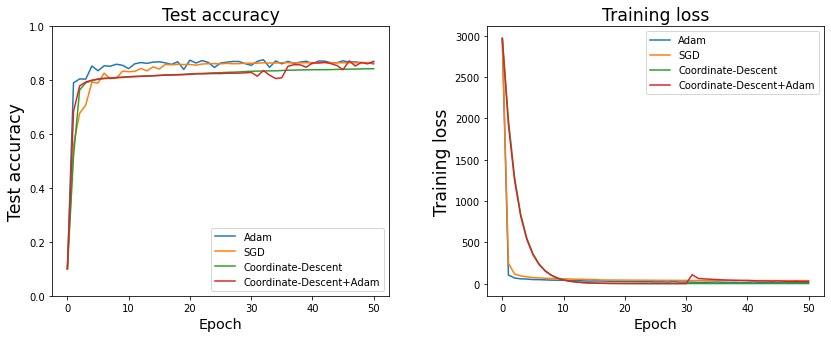

CIFAR10
Average Epoch Times:
Adam : 11.436084351539613
SGD : 11.252708678245545
Coordinate-Descent : 9.31771206855774
Coordinate-Descent+SGD : 10.096099805831908
Test Accuracy:
Adam : 0.4292490433673469
SGD : 0.48702964004205196
Coordinate-Descent : 0.4846
Coordinate-Descent+SGD : 0.48338247805225604


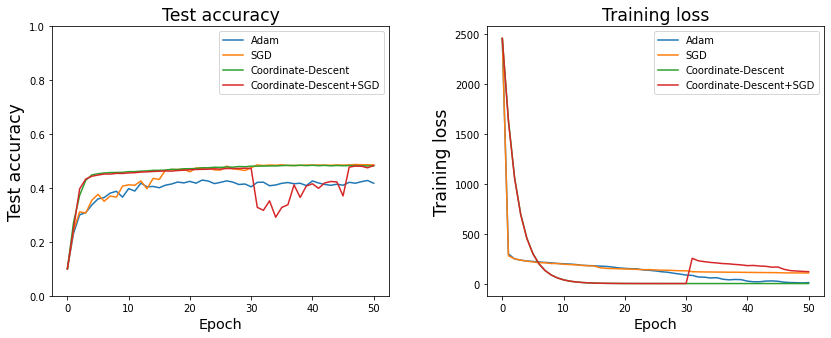

MNIST
Average Epoch Times:
Coordinate-Descent : 0.9772351026535034
Coordinate-Descent-linear_prox : 0.9776805114746093
Test Accuracy:
Coordinate-Descent : 0.9371
Coordinate-Descent-linear_prox : 0.9346


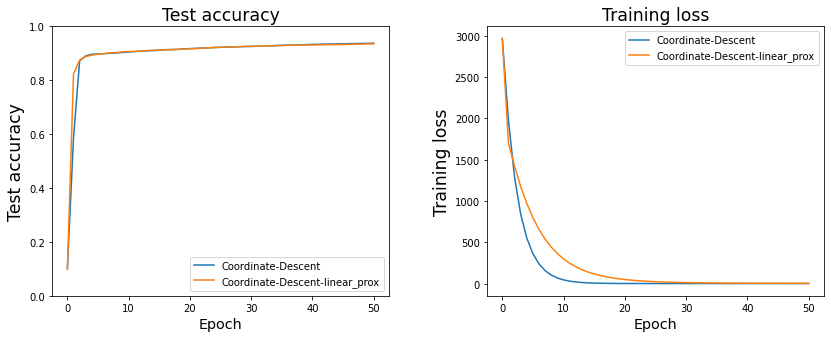

MNIST
Average Epoch Times:
Coordinate-Descent-Entropy : 1.0109007596969604
Test Accuracy:
Coordinate-Descent-Entropy : 0.9315


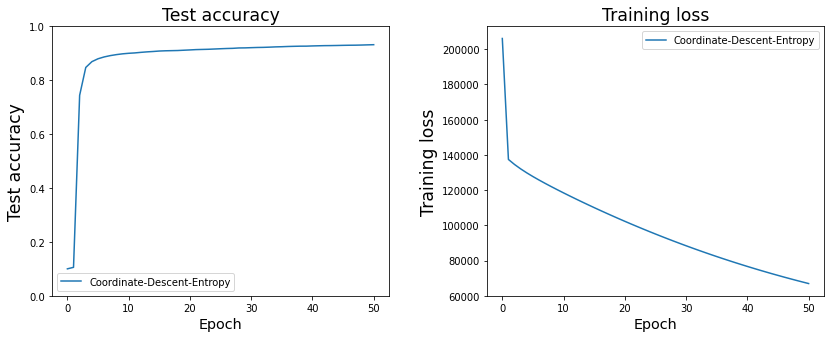

In [61]:
plot_MNIST = True #@param {type:"boolean"}
plot_FMNIST = True #@param {type:"boolean"}
plot_CIFAR10 = True #@param {type:"boolean"}
plot_prox_linear = True #@param {type:"boolean"}
plot_GD_update = True #@param {type:"boolean"}

if(plot_MNIST):
  plot_stats("MNIST",["Adam","SGD","Coordinate-Descent","Coordinate-Descent+Adam"],["Adam","SGD","Coordinate-Descent","Coordinate-Descent+Adam"],"MLP")
if(plot_FMNIST):
  plot_stats("FMNIST",["Adam","SGD","Coordinate-Descent","Coordinate-Descent+Adam"],["Adam","SGD","Coordinate-Descent","Coordinate-Descent+Adam"],"MLP")
if(plot_CIFAR10):
  plot_stats("CIFAR10",["Adam","SGD","Coordinate-Descent","Coordinate-Descent+SGD"],["Adam","SGD","Coordinate-Descent","Coordinate-Descent+SGD"],"MLP")
if(plot_prox_linear):
  plot_stats(dataset_flag,["Coordinate-Descent","Coordinate-Descent-linear_prox"],["Coordinate-Descent","Coordinate-Descent"],"MLP")
if(plot_GD_update):
  plot_stats(dataset_flag,["Coordinate-Descent-Entropy"],["Coordinate-Descent"],"MLP")